# Parallel Computing

## Why go parallel?

<img src="imgs/50-years-processor-trend.png" width=700px>

**Source:** [Karl Rupp, "Microprocessor trend data repository".](https://github.com/karlrupp/microprocessor-trend-data)

## When go parallel?

* If parts of your (optimized!) serial code aren't fast enough.
  * note that parallelization typically increases the code complexity.
* If your system has multiple execution units (CPU cores, GPU streaming multiprocessors, ...).
  * particularly important on large supercomputers but also already on modern personal computers.

## Parallel computing in Julia

There are many types of parallelism:

* **Instruction level parallelism** (e.g. SIMD)
* **Multi-threading** (shared memory)
* **Multi-processing** (shared system memory)
* **Distributed processing** (typically no shared memory)
* **GPU acceleration**

Julia provides support for all types of parallelism mentioned above

|                                                         |                                                                                                                                                                                       |
|---------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Instruction level parallelism** (e.g. SIMD)           | → [`@simd`](https://docs.julialang.org/en/v1/base/base/#Base.SimdLoop.@simd), [SIMD.jl](https://github.com/eschnett/SIMD.jl), ...                                                     |
| **Multi-threading** (shared memory)                     | → [Base.Threads](https://docs.julialang.org/en/v1/base/multi-threading/), [ThreadsX.jl](https://github.com/tkf/ThreadsX.jl), [FLoops.jl](https://github.com/JuliaFolds/FLoops.jl), .. |
| **Multi-processing** (shared system memory)             | → [Distributed.jl](https://docs.julialang.org/en/v1/stdlib/Distributed/), [MPI.jl](https://github.com/JuliaParallel/MPI.jl), ...                                                      |
| **Distributed processing** (typically no shared memory) | → [Distributed.jl](https://docs.julialang.org/en/v1/stdlib/Distributed/), [MPI.jl](https://github.com/JuliaParallel/MPI.jl), ...                                                      |
| **GPU acceleration**                                     | → [CUDA.jl](https://github.com/JuliaGPU/CUDA.jl), [AMDGPU.jl](https://github.com/JuliaGPU/AMDGPU.jl), [KernelAbstractions.jl](https://github.com/JuliaGPU/KernelAbstractions.jl), ... |

## Moderation of expectations

### Amdahl's law (**strong scaling**)

Naive expectation: I have 4 cores, give me my 4x speedup!

> If $p$ is the fraction of a code that can be parallelized, then the maximal theoretical speedup by parallelization on $n$ cores is given by $$ S_a(n) = \frac{1}{(1 - p) + p / n} $$

Let's plot the parallel speedup $S_a(n)$:

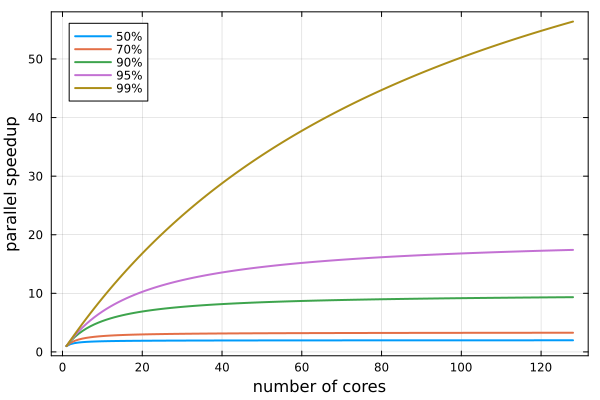

In [23]:
using Plots
S_a(p,n) = 1/(1-p + p/n)

pl = plot()
for p in (0.5, 0.7, 0.9, 0.95, 0.99)
    plot!(pl, n -> S_a(p,n), 1:128, lab="$(Int(p*100))%", lw=2,
        legend=:topleft, xlab="number of cores", ylab="parallel speedup", frame=:box)
end
pl

### Gustafson's law (**weak scaling**)

**Amdahl's law:** fix the total problem size (strong scaling)

**Gustafson's law:** fix the problem size per parallel worker, i.e. total problem size increases (weak scaling)

<!-- > If $p$ is the fraction of a code that can be parallelized, then the maximal theoretical scaled speedup by parallelization on $n$ cores is given by $$ S_g(n) = 1 + (n-1)p $$ -->

Focus on **parallel efficiency** rather than speedup.

$$ E_g(n) = \frac{t(1)}{t(n)}$$

$t(1)$: time it takes to solve a problem of "size $1$" on a single processor

$t(n)$: time it takes to solve a problem of "size $n$" on $n$ parallel processors

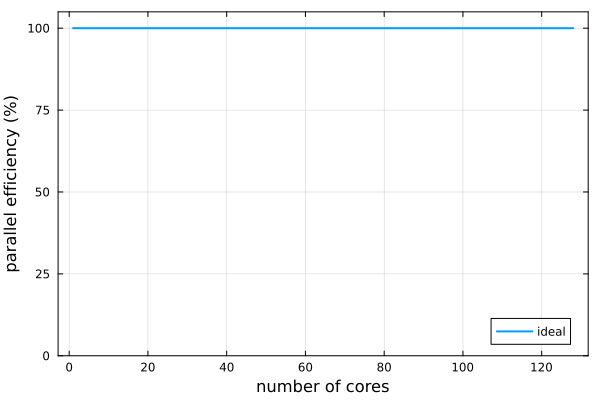

In [53]:
using Plots
S_g(p,n) = 1+(n-1)p

plot(n -> S_g(1,n)/n * 100, 1:128, lab="ideal", lw=2,
xlab="number of cores", ylab="parallel efficiency (%)", frame=:box, ylims=(0,105))

## How many CPU-cores are there?

**Terminology:** CPU-threads = "virtual cores" = "hardware threads" within physical CPU-cores.

In [ ]:
using SysInfo
sysinfo()

Hostname: 	cl7fr1
CPU(s): 	2 x Intel(R) Xeon(R) CPU E5-2670 0 @ 2.60GHz
CPU target: 	sandybridge
Cores: 		16 (32 CPU-threads due to 2-way SMT)
NUMA domains: 	2 (8 cores each)

∘ CPU 1: 
	→ 8 cores (16 CPU-threads due to 2-way SMT)
	→ 1 NUMA domain
∘ CPU 2: 
	→ 8 cores (16 CPU-threads due to 2-way SMT)
	→ 1 NUMA domain


Note that there may be more than one CPU thread per physical CPU core (e.g. hyperthreading).

### HLRS Training Cluster: Compute Node (`skl`)

```julia-repl
Hostname:       n001801
CPU(s):         2 x Intel(R) Xeon(R) Gold 6138 CPU @ 2.00GHz
CPU target:     skylake-avx512
Cores:          40 (80 CPU-threads due to 2-way SMT)
NUMA domains:   2 (20 cores each)

∘ CPU 1: 
        → 20 cores (40 CPU-threads due to 2-way SMT)
        → 1 NUMA domain
∘ CPU 2: 
        → 20 cores (40 CPU-threads due to 2-way SMT)
        → 1 NUMA domain
```

### HLRS Training Cluster: GPU Node (`clx-ai`)

```julia-repl
Hostname:       n010301
CPU(s):         2 x Intel(R) Xeon(R) Gold 6240 CPU @ 2.60GHz
CPU target:     cascadelake
Cores:          36 (72 CPU-threads due to 2-way SMT)
NUMA domains:   2 (18 cores each)

∘ CPU 1: 
        → 18 cores (36 CPU-threads due to 2-way SMT)
        → 1 NUMA domain
∘ CPU 2: 
        → 18 cores (36 CPU-threads due to 2-way SMT)
        → 1 NUMA domain

Detected GPUs:  8
```